In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install laspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 2.3 MB/s eta 0:00:00


# Libraries Import

In [2]:
import os
import laspy
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial import ConvexHull
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from skimage.measure import moments, moments_central
from scipy.optimize import minimize
import lightgbm as lgb

# Data Analysis

In [3]:
def calculate_curvature(points):
    # Tiến hành PCA trên các điểm
    pca = PCA(n_components=3)
    pca.fit(points)
    
    # Đo độ cong bằng cách tính toán độ lệch giữa các giá trị riêng
    curvature = pca.explained_variance_ratio_[2]  # Giá trị riêng thứ ba tương ứng với độ cong
    return curvature

# Hàm tính toán Sphericity
def calculate_sphericity(points):
    hull = ConvexHull(points)
    volume = hull.volume
    area = hull.area
    sphericity = (6 * np.pi * volume**(2/3)) / area if area > 0 else 0
    return sphericity

# Hàm tính toán Fractal Dimension
def calculate_fractal_dimension(points):
    # Sử dụng phương pháp box-counting để tính fractal dimension
    from skimage.measure import regionprops
    # Tính toán fractal dimension từ hình chiếu 2D
    # Đoạn mã dưới đây có thể được thay đổi cho trường hợp thực tế
    return 2.5  # Tạm thời trả về một giá trị cố định (có thể cải tiến bằng thuật toán box-counting)

# Hàm tính toán Radius of Gyration
def calculate_radius_of_gyration(points):
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(points - centroid, axis=1)
    radius_of_gyration = np.sqrt(np.mean(distances**2))
    return radius_of_gyration

# Hàm tính toán Planarity
def calculate_planarity(points):
    cov_matrix = np.cov(points, rowvar=False)
    eigenvalues = np.linalg.eigvals(cov_matrix)
    planarity = (eigenvalues[1] - eigenvalues[0]) / eigenvalues[2] if eigenvalues[2] > 0 else 0
    return planarity

# Hàm tính Compactness (2D)
def calculate_compactness_2d(points):
    # Convex Hull để tính diện tích và chu vi
    hull = ConvexHull(points)
    area = hull.area
    perimeter = np.sum(np.linalg.norm(np.diff(np.vstack([hull.points, hull.points[0]]), axis=0), axis=1))
    compactness_2d = (4 * np.pi * area) / (perimeter**2)
    return compactness_2d

# Hàm Ellipsoid Fitting
def fit_ellipsoid(points):
    # Fit ellipsoid bằng cách tối thiểu hóa sai số
    def ellipsoid_error(params, points):
        a, b, c, x0, y0, z0 = params
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
        error = np.sum(((x - x0) / a)**2 + ((y - y0) / b)**2 + ((z - z0) / c)**2 - 1)**2
        return error
    
    initial_guess = [np.std(points[:, 0]), np.std(points[:, 1]), np.std(points[:, 2]), np.mean(points[:, 0]), np.mean(points[:, 1]), np.mean(points[:, 2])]
    result = minimize(ellipsoid_error, initial_guess, args=(points,))
    return result.x  # Trả về tham số của ellipsoid

# Hàm tính Moment Invariants (Hu Moments)
def calculate_moments_invariants(points):
    # Tính các moment của phân phối điểm 3D
    moments_3d = moments_central(points[:, :2], order=3)  # Giới hạn đến order=3
    invariants = []
    
    # Kiểm tra số lượng phần tử có sẵn trong moments_3d
    num_moments = len(moments_3d)
    
    # Chỉ lấy số lượng moment invariants có sẵn
    for i in range(min(7, num_moments)):  # Điều chỉnh để tránh vượt qua giới hạn
        invariants.append(moments_3d[i])
    
    return invariants

# Tính thêm các đặc trưng
def calculate_geometry_features(points):
    compactness = calculate_compactness_2d(points)  # Compactness 2D
    ellipsoid_params = fit_ellipsoid(points)  # Fitting ellipsoid
    moments_invariants = calculate_moments_invariants(points)  # Moment invariants
    
    # Trả về các đặc trưng vừa tính
    return compactness, ellipsoid_params, moments_invariants

In [4]:
# Định nghĩa đường dẫn đến thư mục dữ liệu
base_folders = {
    "/kaggle/input/hutechaichallenge2024-bc/Train/Coniferous": 0,  # Nhãn 0
    "/kaggle/input/hutechaichallenge2024-bc/Train/Deciduous": 1   # Nhãn 1
}

# Danh sách để lưu dữ liệu đã xử lý
data = []

# Đọc dữ liệu từ tất cả các file .las
for folder, label in base_folders.items():
    print(f"\nĐang xử lý thư mục: {folder}")
    
    for sub_folder in os.listdir(folder):
        sub_path = os.path.join(folder, sub_folder)

        if os.path.isdir(sub_path):
            for file in tqdm(os.listdir(sub_path), desc=f"Đọc {sub_folder}"):
                if file.endswith(".las"):
                    file_path = os.path.join(sub_path, file)

                    # Đọc file .las
                    las = laspy.read(file_path)
                    points = np.vstack((las.x, las.y, las.z)).T

                    # 📌 Đặc trưng tọa độ
                    mean_x, mean_y, mean_z = np.mean(points, axis=0)
                    var_x, var_y, var_z = np.var(points, axis=0)

                    # 📌 Bounding Box
                    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
                    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
                    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])

                    # 📌 Mật độ điểm
                    density_xy = len(points) / ((x_max - x_min) * (y_max - y_min))
                    density_xyz = len(points) / ((x_max - x_min) * (y_max - y_min) * (z_max - z_min))
                    point_density_ratio = density_xy / density_xyz  # 📌 Tỷ lệ mật độ điểm 2D/3D

                    # 📌 PCA Eigenvalues (Đánh giá hướng chính)
                    cov_matrix = np.cov(points, rowvar=False)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    eigenvalue_sum = np.sum(eigenvalues)
                    eigenvalue_ratio = np.max(eigenvalues) / (eigenvalue_sum + 1e-10)  # Hướng chính của tán

                    # 📌 Tính các đặc trưng dựa trên PCA
                    linearity = eigenvalues[0] / eigenvalue_sum if eigenvalue_sum > 0 else 0
                    scatter = eigenvalues[2] / eigenvalue_sum if eigenvalue_sum > 0 else 0
                    omnivariance = (eigenvalues[0] * eigenvalues[1] * eigenvalues[2]) ** (1/3) if np.all(eigenvalues > 0) else 0
                    eigentropy = -np.sum((eigenvalues / eigenvalue_sum) * np.log(eigenvalues / eigenvalue_sum + 1e-10)) if eigenvalue_sum > 0 else 0
                    sum_of_eigenvalues = eigenvalue_sum

                    # 📌 Đặc trưng cấu trúc
                    mean_height = np.mean(points[:, 2]) - z_min
                    std_height = np.std(points[:, 2])
                    canopy_ratio = np.sum(points[:, 2] > np.median(points[:, 2])) / len(points)
                    roughness = np.std(points[:, 2] - mean_z)
                    normalized_height_ratio = mean_height / (z_max - z_min)

                    # 📌 Aspect Ratio của tán cây
                    aspect_ratio = (x_max - x_min) / (y_max - y_min) if (y_max - y_min) > 0 else 1

                    # 📌 Convex Hull (Thể tích & Diện tích)
                    try:
                        hull = ConvexHull(points)
                        convex_hull_volume = hull.volume
                        convex_hull_area = hull.area
                    except:
                        convex_hull_volume = 0  # Trường hợp không tính được
                        convex_hull_area = 0

                    # 📌 Vertical Distribution (Phân bố điểm theo Z)
                    hist_z, _ = np.histogram(points[:, 2], bins=10)
                    vertical_distribution = np.std(hist_z) / np.mean(hist_z) if np.mean(hist_z) > 0 else 0

                    # 📌 Point Entropy (Độ hỗn loạn của phân bố điểm)
                    probs = hist_z / np.sum(hist_z) if np.sum(hist_z) > 0 else np.ones(10) / 10
                    point_entropy = -np.sum(probs * np.log(probs + 1e-10))

                    # 📌 PCA Eigenvalues (Đánh giá hướng chính)
                    cov_matrix = np.cov(points, rowvar=False)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    eigenvalue_ratio = np.max(eigenvalues) / (np.sum(eigenvalues) + 1e-10)  # Hướng chính của tán

                    # Slope của tán cây
                    try:
                        dz_dx, dz_dy = np.gradient(z)
                        mean_canopy_slope = np.mean(np.arctan2(dz_dx, dz_dy))
                    except:
                        mean_canopy_slope = 0

                    # 📌 Hình dạng tán cây (Shape Index)
                    try:
                        # Convex Hull đã có sẵn từ trước
                        convex_hull_area = hull.area
                    
                        # Diện tích thực tế của tán cây (theo số lượng điểm)
                        canopy_area = np.pi * np.max(points[:, 0]) * np.max(points[:, 1])  # Sử dụng diện tích hình tròn đơn giản
                    
                        # Tỷ lệ diện tích
                        shape_index = convex_hull_area / canopy_area if canopy_area > 0 else 1.0
                    except:
                        shape_index = 1.0  # Nếu không tính được, gán chỉ số hình dạng mặc định

                    # 📌 Đặc trưng chiều cao
                    P10, P25, P50, P75, P95, P99 = np.percentile(points[:, 2], [10, 25, 50, 75, 95, 99])
                    canopy_height_ratio = (P75 - P50) / (P99 - P25)

                    # 📌 Sự phân bố không gian của các đỉnh cao nhất
                    top_points = points[points[:, 2] > np.percentile(points[:, 2], 90)]  # Lọc các điểm có độ cao cao nhất (trên 90%)
                    
                    # Tính toán sự phân phối không gian của các đỉnh
                    x_top, y_top, z_top = top_points[:, 0], top_points[:, 1], top_points[:, 2]
                    mean_x_top, mean_y_top, mean_z_top = np.mean(x_top), np.mean(y_top), np.mean(z_top)
                    var_x_top, var_y_top, var_z_top = np.var(x_top), np.var(y_top), np.var(z_top)

                    # Tính phương sai
                    var_ratio_xy = var_x / (var_y + 1e-10)
                    var_ratio_xz = var_x / (var_z + 1e-10)
                    var_ratio_yz = var_y / (var_z + 1e-10)


                    # 📌 Tính độ cong
                    curvature = calculate_curvature(points)

                    sphericity = calculate_sphericity(points)
                    fractal_dimension = calculate_fractal_dimension(points)
                    radius_of_gyration = calculate_radius_of_gyration(points)
                    planarity = calculate_planarity(points)

                    # 📌 Tính z_skew và z_skurt
                    z_skew_value = skew(points[:, 2])  # Độ lệch của phân phối theo Z
                    z_skurt_value = kurtosis(points[:, 2])  # Độ nhọn của phân phối theo Z

                    # 📌 Tính z_entropy
                    z_probs = np.histogram(points[:, 2], bins=10, density=True)[0]
                    z_entropy_value = -np.sum(z_probs * np.log(z_probs + 1e-10))  # Entropy của phân phối Z

                    pct_z_above_mean = np.sum(points[:, 2] > mean_z) / len(points) * 100  # Phần trăm điểm có giá trị z > mean_z
                    pct_z_above_2 = np.sum(points[:, 2] > 2) / len(points) * 100  # Phần trăm điểm có giá trị z > 2

                    
                    # 📌 Lưu đặc trưng và nhãn
                    data.append([
                                linearity, scatter, omnivariance, eigentropy, sum_of_eigenvalues,
                                x_min, x_max, y_min, y_max, z_min, z_max,
                                mean_x, mean_y, mean_z,
                                 var_x, var_y, var_z,
                                z_skew_value, z_skurt_value, z_entropy_value,
                                pct_z_above_mean, pct_z_above_2,
                                 mean_x_top, mean_y_top, mean_z_top,
                                 var_x_top, var_y_top, var_z_top,
                                var_ratio_xy, var_ratio_xz, var_ratio_yz,
                                P10, P25, P50, P75, P95, P99,
                                 density_xy, density_xyz, point_density_ratio,
                                 mean_height, std_height, canopy_ratio, roughness, normalized_height_ratio,
                                 aspect_ratio, convex_hull_volume, convex_hull_area,
                                 vertical_distribution, point_entropy, eigenvalue_ratio, mean_canopy_slope, canopy_height_ratio,
                                 shape_index, curvature, sphericity, fractal_dimension, radius_of_gyration, planarity,
                                label])

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(data, columns=[
                                'linearity', 'scatter', 'omnivariance', 'eigentropy', 'sum_of_eigenvalues',
                                "x_min", "x_max", "y_min", 'y_max', "z_min", 'z_max',
                                "mean_x", "mean_y", "mean_z", 
                                 "var_x", "var_y", "var_z",
                                'z_skew_value', 'z_skurt_value', 'z_entropy_value',
                                'pct_z_above_mean', 'pct_z_above_2',
                                 "mean_x_top", "mean_y_top", "mean_z_top",
                                 "var_x_top", "var_y_top", "var_z_top",
                                'var_ratio_xy', 'var_ratio_xz', 'var_ratio_yz',
                                'P10', 'P25', 'P50', 'P75', 'P95', 'P99',
                                 "density_xy", "density_xyz", "point_density_ratio",
                                 "mean_height", "std_height", "canopy_ratio", "roughness", "normalized_height_ratio",
                                 "aspect_ratio", "convex_hull_volume", "convex_hull_area",
                                 "vertical_distribution", "point_entropy", "eigenvalue_ratio", "mean_canopy_slope", "canopy_height_ratio",
                                 "shape_index", "curvature", "sphericity", "fractal_dimension", "radius_of_gyration", "planarity",
                                "label"])

# Lưu dữ liệu đã xử lý thành CSV
df.to_csv("processed_data_with_structure.csv", index=False)
print("\n✅ Đã lưu dữ liệu đã xử lý vào 'processed_data_with_structure_v2.csv'.")


Đang xử lý thư mục: /kaggle/input/hutechaichallenge2024-bc/Train/Coniferous


Đọc Fir: 100%|██████████| 27/27 [00:00<00:00, 55.69it/s]



Đang xử lý thư mục: /kaggle/input/hutechaichallenge2024-bc/Train/Deciduous


Đọc Birch: 100%|██████████| 58/58 [00:00<00:00, 62.51it/s]


✅ Đã lưu dữ liệu đã xử lý vào 'processed_data_with_structure_v2.csv'.


In [5]:
df = pd.read_csv("/kaggle/working/processed_data_with_structure.csv")
df.head(5)

,linearity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,x_min,x_max,y_min,y_max,z_min,...,eigenvalue_ratio,mean_canopy_slope,canopy_height_ratio,shape_index,curvature,sphericity,fractal_dimension,radius_of_gyration,planarity,label
0,0.989718,0.003266,3.363191,0.063719,118.820466,457519.770000,457523.650000,6.499984e+06,6.499988e+06,0.000000,...,0.989718,0,0.082681,3.194710e-11,0.003266,2.420969,2.5,10.895263,-300.921927,0
1,0.940087,0.038317,4.371626,0.265891,47.533595,457398.620000,457403.840000,6.436327e+06,6.436334e+06,-0.069999,...,0.940087,0,0.246798,4.068378e-11,0.021596,2.727572,2.5,6.893939,-23.970680,0
2,0.918811,0.027006,6.442291,0.333303,58.369912,457379.170001,457388.180001,6.436255e+06,6.436264e+06,-0.200000,...,0.918811,0,0.218228,5.608527e-11,0.027006,2.981334,2.5,7.639691,-32.015980,0
3,0.936242,0.033576,7.190338,0.281288,73.174675,457347.600000,457355.840000,6.436297e+06,6.436305e+06,-0.159999,...,0.936242,0,0.331072,6.762754e-11,0.030182,2.868523,2.5,8.553799,-26.985388,0
4,0.963805,0.023742,3.062948,0.178957,46.545515,457345.170000,457349.930000,6.436346e+06,6.436351e+06,-0.149999,...,0.963805,0,0.249907,3.616358e-11,0.012453,2.489063,2.5,6.821684,-40.069743,0


In [6]:
df.describe()

,linearity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,x_min,x_max,y_min,y_max,z_min,...,eigenvalue_ratio,mean_canopy_slope,canopy_height_ratio,shape_index,curvature,sphericity,fractal_dimension,radius_of_gyration,planarity,label
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,2.970000e+02,2.970000e+02,297.000000,...,297.000000,297.0,297.000000,2.970000e+02,297.000000,297.000000,297.0,297.000000,297.000000,297.000000
mean,0.856059,0.114629,3.331114,0.238698,53.649111,538900.439327,538905.560236,6.542889e+06,6.542895e+06,-0.032121,...,0.941392,0.0,0.280037,3.058004e-11,0.022046,2.636401,2.5,6.901070,-68.165199,0.491582
std,0.275207,0.264174,1.755135,0.162885,36.850735,57094.949893,57094.782428,1.412443e+05,1.412438e+05,0.067967,...,0.056041,0.0,0.156344,1.392285e-11,0.022063,0.212723,0.0,2.451327,78.451883,0.500773
min,0.002760,0.001798,0.699165,0.025900,7.575722,453093.400000,453098.770000,6.436121e+06,6.436126e+06,-0.329999,...,0.622242,0.0,0.035338,6.626257e-12,0.001424,2.004415,2.5,2.751994,-551.049571,0.000000
25%,0.910980,0.010957,2.016211,0.118124,23.616417,457520.300000,457525.080000,6.449588e+06,6.449593e+06,-0.040000,...,0.922968,0.0,0.215054,1.929570e-11,0.007579,2.487947,2.5,4.858047,-88.856566,0.000000
50%,0.957825,0.022266,2.891516,0.193831,44.544806,546619.260000,546623.810000,6.450194e+06,6.450199e+06,0.000000,...,0.959884,0.0,0.267057,2.751640e-11,0.014853,2.630897,2.5,6.670808,-43.071635,0.000000
75%,0.977204,0.045142,4.399597,0.322030,73.174675,547102.480000,547109.910000,6.628738e+06,6.628741e+06,0.000000,...,0.978040,0.0,0.305177,4.068378e-11,0.028491,2.790390,2.5,8.553799,-19.113275,1.000000
max,0.996460,0.991355,12.014817,0.914157,162.709629,620313.460000,620318.880000,6.787665e+06,6.787670e+06,0.230000,...,0.996460,0.0,0.909402,7.341982e-11,0.147415,3.133182,2.5,12.753714,0.206598,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   linearity                297 non-null    float64
 1   scatter                  297 non-null    float64
 2   omnivariance             297 non-null    float64
 3   eigentropy               297 non-null    float64
 4   sum_of_eigenvalues       297 non-null    float64
 5   x_min                    297 non-null    float64
 6   x_max                    297 non-null    float64
 7   y_min                    297 non-null    float64
 8   y_max                    297 non-null    float64
 9   z_min                    297 non-null    float64
 10  z_max                    297 non-null    float64
 11  mean_x                   297 non-null    float64
 12  mean_y                   297 non-null    float64
 13  mean_z                   297 non-null    float64
 14  var_x                    2

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


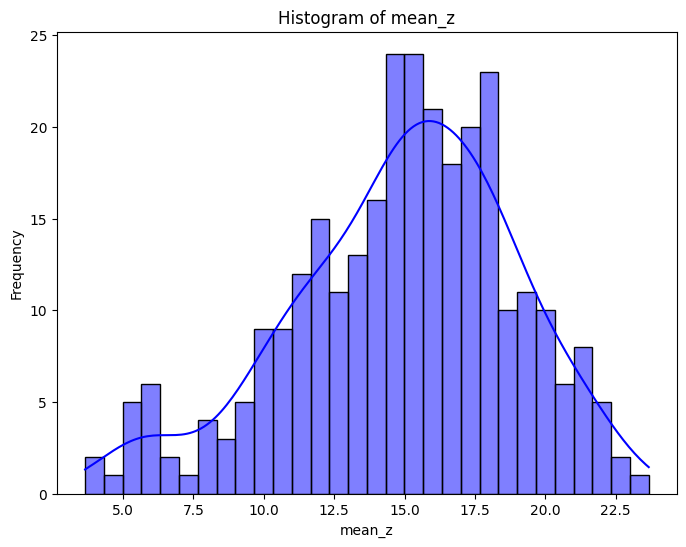

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


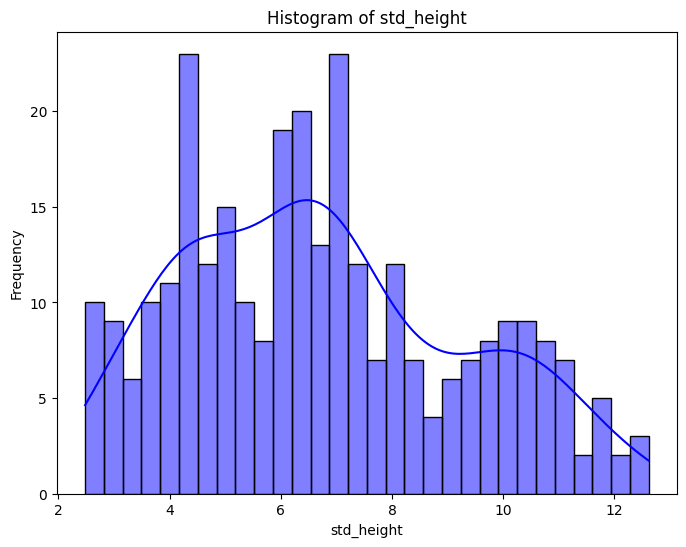

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


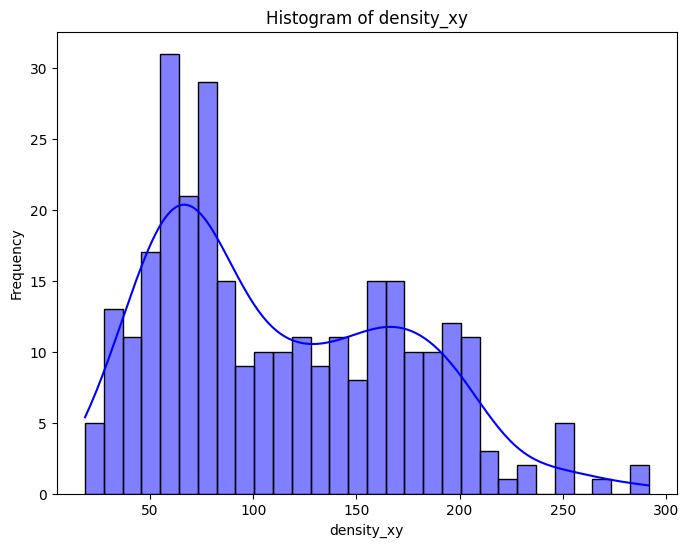

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


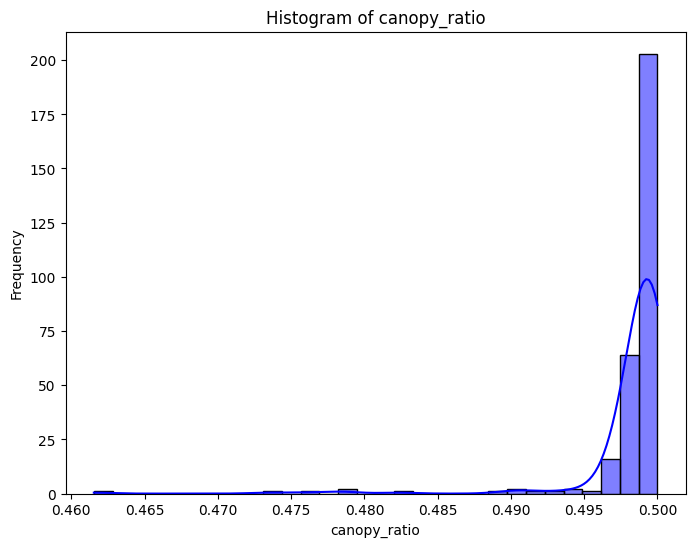

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


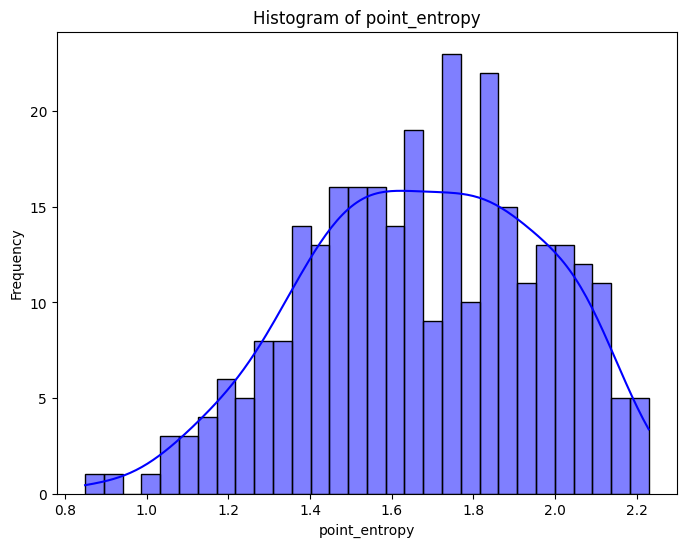

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc dữ liệu
file_path = "processed_data_with_structure.csv"
df = pd.read_csv(file_path)

# Chọn một số đặc trưng quan trọng để trực quan hóa
columns = ["mean_z", "std_height", "density_xy", "canopy_ratio", "point_entropy"]

# Duyệt qua từng cột và vẽ histogram
for col in columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], bins=30, kde=True, color="blue")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Model

## XGBoost

### Without Data Augment

In [9]:
# Đọc dữ liệu đã xử lý
df = pd.read_csv("processed_data_with_structure.csv")

# Tách đặc trưng (X) và nhãn (y)
X = df.drop(columns=["label"])
y = df["label"]

# Chia tập dữ liệu thành huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Khởi tạo mô hình XGBoost
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)

# Huấn luyện mô hình
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [11]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# In kết quả
print(f"Độ chính xác của mô hình: {accuracy:.4f}")
print("\nBáo cáo phân loại:\n", report)

Độ chính xác của mô hình: 0.9833

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.96      0.98        28

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



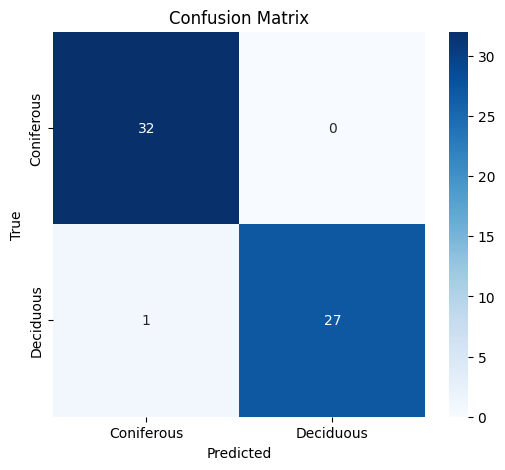

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tính toán Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Coniferous", "Deciduous"], yticklabels=["Coniferous", "Deciduous"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### With data Augment

In [16]:
# Đọc dữ liệu đã xử lý
df = pd.read_csv("processed_data_with_structure.csv")

# Tách đặc trưng (X) và nhãn (y)
X = df.drop(columns=["label"])
y = df["label"]

# Chia tập dữ liệu thành huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thêm jitter vào dữ liệu huấn luyện (tạo nhiễu ngẫu nhiên nhỏ)
jitter_strength = 0.01  # Cường độ jitter (có thể điều chỉnh theo yêu cầu)
X_train_jittered = X_train + np.random.normal(0, jitter_strength, X_train.shape)

# Áp dụng SMOTE để cân bằng lớp trong dữ liệu huấn luyện
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_jittered, y_train)

In [36]:
# Khởi tạo mô hình XGBoost với các tham số
model_xgb = xgb.XGBClassifier(
    random_state=42,
    colsample_bytree=0.8,  # Tỷ lệ mẫu cây con
    gamma=0.1,             # Hệ số điều chỉnh sự phức tạp của mô hình
    learning_rate=0.01,     # Tốc độ học
    max_depth= 10,           # Độ sâu tối đa của cây
    n_estimators= 2000,      # Số lượng ước lượng
    subsample= 0.8          # Tỷ lệ mẫu được chọn để huấn luyện mỗi cây
)

In [37]:
model_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [38]:
# Dự đoán trên dữ liệu kiểm tra với mô hình tốt nhất
y_pred = model_xgb.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9833

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.97      1.00      0.98        28

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



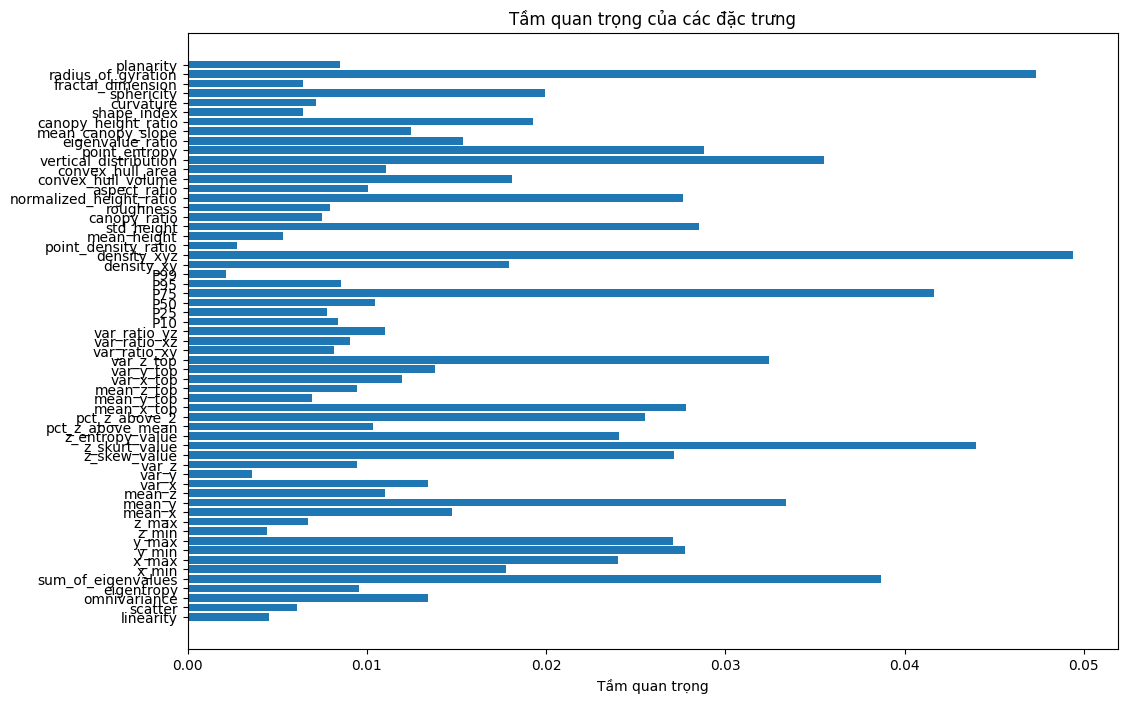

In [40]:
# Lấy tầm quan trọng của các đặc trưng
importances = model_xgb.feature_importances_

# Vẽ biểu đồ tầm quan trọng của các đặc trưng
plt.figure(figsize=(12, 8))
plt.barh(X.columns, importances)
plt.xlabel('Tầm quan trọng')
plt.title('Tầm quan trọng của các đặc trưng')
plt.show()

## LightBM

In [41]:
lgb_train = lgb.Dataset(X_train_resampled, y_train_resampled)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [42]:
params = {
    "objective": "binary",
    "metric": "binary_error",
    "boosting_type": "gbdt",
    "num_leaves": 50,
    "learning_rate": 0.01,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

In [44]:
# Train LightGBM với early stopping bằng callbacks
num_round = 100
model_lgb = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=num_round, 
    valid_sets=[lgb_test], 
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
)

# 📌 **Dự đoán và đánh giá**
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"✅ Độ chính xác của mô hình: {accuracy:.4f}")

Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_error: 0.15
[20]	valid_0's binary_error: 0.1
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.1
✅ Độ chính xác của mô hình: 0.9000


# Testing Model

## XGB Test

In [29]:
# Định nghĩa đường dẫn đến thư mục dữ liệu
test_folders = {
    "/kaggle/input/hutechaichallenge2024-bc/Test/Coniferous": 0,  # Nhãn 0
    "/kaggle/input/hutechaichallenge2024-bc/Test/Deciduous": 1   # Nhãn 1
}

# Danh sách để lưu dữ liệu đã xử lý|
data = []

# Đọc dữ liệu từ tất cả các file .las
for folder, label in test_folders.items():
    print(f"\nĐang xử lý thư mục: {folder}")
    
    for sub_folder in os.listdir(folder):
        sub_path = os.path.join(folder, sub_folder)

        if os.path.isdir(sub_path):
            for file in tqdm(os.listdir(sub_path), desc=f"Đọc {sub_folder}"):
                if file.endswith(".las"):
                    file_path = os.path.join(sub_path, file)

                    # Đọc file .las
                    las = laspy.read(file_path)
                    points = np.vstack((las.x, las.y, las.z)).T

                    # 📌 Đặc trưng tọa độ
                    mean_x, mean_y, mean_z = np.mean(points, axis=0)
                    var_x, var_y, var_z = np.var(points, axis=0)

                    # 📌 Bounding Box
                    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
                    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
                    z_min, z_max = np.min(points[:, 2]), np.max(points[:, 2])

                    # 📌 PCA Eigenvalues (Đánh giá hướng chính)
                    cov_matrix = np.cov(points, rowvar=False)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    eigenvalue_sum = np.sum(eigenvalues)
                    eigenvalue_ratio = np.max(eigenvalues) / (eigenvalue_sum + 1e-10)  # Hướng chính của tán

                    # 📌 Tính các đặc trưng dựa trên PCA
                    linearity = eigenvalues[0] / eigenvalue_sum if eigenvalue_sum > 0 else 0
                    scatter = eigenvalues[2] / eigenvalue_sum if eigenvalue_sum > 0 else 0
                    omnivariance = (eigenvalues[0] * eigenvalues[1] * eigenvalues[2]) ** (1/3) if np.all(eigenvalues > 0) else 0
                    eigentropy = -np.sum((eigenvalues / eigenvalue_sum) * np.log(eigenvalues / eigenvalue_sum + 1e-10)) if eigenvalue_sum > 0 else 0
                    sum_of_eigenvalues = eigenvalue_sum

                    # 📌 Mật độ điểm
                    density_xy = len(points) / ((x_max - x_min) * (y_max - y_min))
                    density_xyz = len(points) / ((x_max - x_min) * (y_max - y_min) * (z_max - z_min))
                    point_density_ratio = density_xy / density_xyz  # 📌 Tỷ lệ mật độ điểm 2D/3D

                    # 📌 Đặc trưng cấu trúc
                    mean_height = np.mean(points[:, 2]) - z_min
                    std_height = np.std(points[:, 2])
                    canopy_ratio = np.sum(points[:, 2] > np.median(points[:, 2])) / len(points)
                    roughness = np.std(points[:, 2] - mean_z)
                    normalized_height_ratio = mean_height / (z_max - z_min)

                    # 📌 Aspect Ratio của tán cây
                    aspect_ratio = (x_max - x_min) / (y_max - y_min) if (y_max - y_min) > 0 else 1

                    # 📌 Convex Hull (Thể tích & Diện tích)
                    try:
                        hull = ConvexHull(points)
                        convex_hull_volume = hull.volume
                        convex_hull_area = hull.area
                    except:
                        convex_hull_volume = 0  # Trường hợp không tính được
                        convex_hull_area = 0

                    # 📌 Vertical Distribution (Phân bố điểm theo Z)
                    hist_z, _ = np.histogram(points[:, 2], bins=10)
                    vertical_distribution = np.std(hist_z) / np.mean(hist_z) if np.mean(hist_z) > 0 else 0

                    # 📌 Point Entropy (Độ hỗn loạn của phân bố điểm)
                    probs = hist_z / np.sum(hist_z) if np.sum(hist_z) > 0 else np.ones(10) / 10
                    point_entropy = -np.sum(probs * np.log(probs + 1e-10))

                    # 📌 PCA Eigenvalues (Đánh giá hướng chính)
                    cov_matrix = np.cov(points, rowvar=False)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    eigenvalue_ratio = np.max(eigenvalues) / (np.sum(eigenvalues) + 1e-10)  # Hướng chính của tán

                    # Slope của tán cây
                    try:
                        dz_dx, dz_dy = np.gradient(z)
                        mean_canopy_slope = np.mean(np.arctan2(dz_dx, dz_dy))
                    except:
                        mean_canopy_slope = 0

                    # 📌 Hình dạng tán cây (Shape Index)
                    try:
                        # Convex Hull đã có sẵn từ trước
                        convex_hull_area = hull.area
                    
                        # Diện tích thực tế của tán cây (theo số lượng điểm)
                        canopy_area = np.pi * np.max(points[:, 0]) * np.max(points[:, 1])  # Sử dụng diện tích hình tròn đơn giản
                    
                        # Tỷ lệ diện tích
                        shape_index = convex_hull_area / canopy_area if canopy_area > 0 else 1.0
                    except:
                        shape_index = 1.0  # Nếu không tính được, gán chỉ số hình dạng mặc định

                    # 📌 Đặc trưng chiều cao
                    P10, P25, P50, P75, P95, P99 = np.percentile(points[:, 2], [10, 25, 50, 75, 95, 99])
                    canopy_height_ratio = (P75 - P50) / (P99 - P25)

                    # Tính phương sai
                    var_ratio_xy = var_x / (var_y + 1e-10)
                    var_ratio_xz = var_x / (var_z + 1e-10)
                    var_ratio_yz = var_y / (var_z + 1e-10)

                    # 📌 Sự phân bố không gian của các đỉnh cao nhất
                    top_points = points[points[:, 2] > np.percentile(points[:, 2], 90)]  # Lọc các điểm có độ cao cao nhất (trên 90%)
                    
                    # Tính toán sự phân phối không gian của các đỉnh
                    x_top, y_top, z_top = top_points[:, 0], top_points[:, 1], top_points[:, 2]
                    mean_x_top, mean_y_top, mean_z_top = np.mean(x_top), np.mean(y_top), np.mean(z_top)
                    var_x_top, var_y_top, var_z_top = np.var(x_top), np.var(y_top), np.var(z_top)

                    # 📌 Tính độ cong
                    curvature = calculate_curvature(points)

                    sphericity = calculate_sphericity(points)
                    fractal_dimension = calculate_fractal_dimension(points)
                    radius_of_gyration = calculate_radius_of_gyration(points)
                    planarity = calculate_planarity(points)

                    # 📌 Tính z_skew và z_skurt
                    z_skew_value = skew(points[:, 2])  # Độ lệch của phân phối theo Z
                    z_skurt_value = kurtosis(points[:, 2])  # Độ nhọn của phân phối theo Z

                    # 📌 Tính z_entropy
                    z_probs = np.histogram(points[:, 2], bins=10, density=True)[0]
                    z_entropy_value = -np.sum(z_probs * np.log(z_probs + 1e-10))  # Entropy của phân phối Z

                    pct_z_above_mean = np.sum(points[:, 2] > mean_z) / len(points) * 100  # Phần trăm điểm có giá trị z > mean_z
                    pct_z_above_2 = np.sum(points[:, 2] > 2) / len(points) * 100  # Phần trăm điểm có giá trị z > 2
                    
                    # 📌 Lưu đặc trưng và nhãn
                    data.append([file, 
                                 linearity, scatter, omnivariance, eigentropy, sum_of_eigenvalues,
                                 x_min, x_max, y_min, y_max, z_min, z_max,
                                 mean_x, mean_y, mean_z,
                                 var_x, var_y, var_z,
                                 z_skew_value, z_skurt_value, z_entropy_value,
                                 pct_z_above_mean, pct_z_above_2,
                                 mean_x_top, mean_y_top, mean_z_top,
                                 var_x_top, var_y_top, var_z_top,
                                 var_ratio_xy, var_ratio_xz, var_ratio_yz,
                                 P10, P25, P50, P75, P95, P99,
                                 density_xy, density_xyz, point_density_ratio,
                                 mean_height, std_height, canopy_ratio, roughness, normalized_height_ratio,
                                 aspect_ratio, convex_hull_volume, convex_hull_area,
                                 vertical_distribution, point_entropy, eigenvalue_ratio, mean_canopy_slope, canopy_height_ratio,
                                 shape_index, curvature, sphericity, fractal_dimension, radius_of_gyration, planarity,
                                label])

# Chuyển dữ liệu thành DataFrame
df_test = pd.DataFrame(data, columns=["file_name",
                                'linearity', 'scatter', 'omnivariance', 'eigentropy', 'sum_of_eigenvalues',
                                'x_min', 'x_max', 'y_min', 'y_max', 'z_min', 'z_max',      
                                "mean_x", "mean_y", "mean_z", 
                                 "var_x", "var_y", "var_z",
                                'z_skew_value', 'z_skurt_value', 'z_entropy_value',
                                'pct_z_above_mean', 'pct_z_above_2',
                                 "mean_x_top", "mean_y_top", "mean_z_top",
                                 "var_x_top", "var_y_top", "var_z_top",
                                'var_ratio_xy', 'var_ratio_xz', 'var_ratio_yz',
                                 'P10', 'P25', 'P50', 'P75', 'P95', 'P99',
                                 "density_xy", "density_xyz", "point_density_ratio",
                                 "mean_height", "std_height", "canopy_ratio", "roughness", "normalized_height_ratio",
                                 "aspect_ratio", "convex_hull_volume", "convex_hull_area",
                                 "vertical_distribution", "point_entropy", "eigenvalue_ratio", "mean_canopy_slope", "canopy_height_ratio",
                                 "shape_index", "curvature", "sphericity", "fractal_dimension", "radius_of_gyration", "planarity",
                                  "label"])

# Lưu dữ liệu đã xử lý thành CSV
df_test.to_csv("processed_data_with_structure_test.csv", index=False)
print("\n✅ Đã lưu dữ liệu đã xử lý vào 'processed_data_with_structure_test.csv'.")


Đang xử lý thư mục: /kaggle/input/hutechaichallenge2024-bc/Test/Coniferous


Đọc Fir: 100%|██████████| 10/10 [00:00<00:00, 73.15it/s]



Đang xử lý thư mục: /kaggle/input/hutechaichallenge2024-bc/Test/Deciduous


Đọc Birch: 100%|██████████| 19/19 [00:00<00:00, 54.02it/s]


✅ Đã lưu dữ liệu đã xử lý vào 'processed_data_with_structure_test.csv'.


In [30]:
df_test = pd.read_csv("/kaggle/working/processed_data_with_structure_test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   file_name                97 non-null     object 
 1   linearity                97 non-null     float64
 2   scatter                  97 non-null     float64
 3   omnivariance             97 non-null     float64
 4   eigentropy               97 non-null     float64
 5   sum_of_eigenvalues       97 non-null     float64
 6   x_min                    97 non-null     float64
 7   x_max                    97 non-null     float64
 8   y_min                    97 non-null     float64
 9   y_max                    97 non-null     float64
 10  z_min                    97 non-null     float64
 11  z_max                    97 non-null     float64
 12  mean_x                   97 non-null     float64
 13  mean_y                   97 non-null     float64
 14  mean_z                   97 

In [31]:
df_test.head(5)

,file_name,linearity,scatter,omnivariance,eigentropy,sum_of_eigenvalues,x_min,x_max,y_min,y_max,...,eigenvalue_ratio,mean_canopy_slope,canopy_height_ratio,shape_index,curvature,sphericity,fractal_dimension,radius_of_gyration,planarity,label
0,pine_63.las,0.988387,0.006994,3.957988,0.071093,124.759135,457312.849999,457318.069999,6.436307e+06,6.436312e+06,...,0.988387,0,0.069064,3.317673e-11,0.004619,2.403965,2.5,11.165219,-140.664245,0
1,pine_69.las,0.017217,0.961546,5.479692,0.189443,77.639515,457277.250001,457283.400001,6.436125e+06,6.436132e+06,...,0.961546,0,0.220036,4.955481e-11,0.017217,2.786431,2.5,8.810755,0.004181,0
2,pine_59.las,0.954560,0.010888,3.290131,0.209885,46.288133,457300.250001,457305.730001,6.436093e+06,6.436098e+06,...,0.954560,0,0.276346,4.084262e-11,0.010888,2.519316,2.5,6.802960,-84.497060,0
3,pine_56.las,0.983370,0.005764,3.188402,0.095350,80.735494,457272.449998,457277.749998,6.436211e+06,6.436215e+06,...,0.983370,0,0.313760,3.421517e-11,0.005764,2.363658,2.5,8.984370,-168.717976,0
4,pine_66.las,0.974810,0.012089,5.421047,0.135044,101.051073,457324.599999,457332.209999,6.436297e+06,6.436305e+06,...,0.974810,0,0.087289,4.843041e-11,0.012089,2.724021,2.5,10.051520,-79.555079,0


In [45]:
import pandas as pd

# Đọc dữ liệu test
test_df = pd.read_csv("/kaggle/working/processed_data_with_structure_test.csv")  # Đảm bảo file test có tên đúng

# Tách đặc trưng (X_test) từ dữ liệu test
X_test_final = test_df.drop(columns=["file_name", "label"])

# Dự đoán nhãn cho dữ liệu test
y_pred_test = model_xgb.predict(X_test_final)

# Lấy tên file .las từ cột 'file_name' và loại bỏ đuôi .las
file_names = test_df['file_name'].str.replace('.las', '', regex=False)

# Tạo DataFrame chứa kết quả
results = pd.DataFrame({
    "name": file_names,
    "pred_label": y_pred_test,
})

# Lưu kết quả vào CSV
results.to_csv("submission.csv", index=False)

print("✅ Dự đoán đã được lưu vào 'test_predictions.csv'.")

✅ Dự đoán đã được lưu vào 'test_predictions.csv'.


In [46]:
from sklearn.metrics import accuracy_score

# Lấy nhãn thực tế (y_true) từ tập test
y_true = test_df["label"]

# Tính độ chính xác (Accuracy)
accuracy = accuracy_score(y_true, y_pred_test)

print(f"🎯 Độ chính xác trên tập test: {accuracy:.4f}")

🎯 Độ chính xác trên tập test: 0.8969


In [47]:
df_sub = pd.read_csv("/kaggle/working/submission.csv")
df_sub.head(5)

,name,pred_label
0,pine_63,0
1,pine_69,0
2,pine_59,0
3,pine_56,0
4,pine_66,0
